<a href="https://colab.research.google.com/github/colemaya/YB_Photometry/blob/master/YB_phot_colemanedits_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instructions and Notes #


Code authors: Katie Devine/Anupa Poudyal/Makenzie Stapley

Code summary: Opens images of YBs and prompts users to click around YB images at 8, 12, 24, and 70 um. Polygon mask is then applied, and background interpolation done. Residual (original-background) is used to calculate total flux density in Jy Output files are a table of the photometric results and images showing the mask, interpolation, and residual. Output file contains the pixels selected for mask/polygon and photometry results.

This code requires that the 8, 12, 24, and 70 um mosaics all have the same dimensions (i.e. that the 12, 24 and 70 um mosaics have been reprojected to match the 8 um pixel size)

Conventions:
Mips in red, Glimpse in green
Longer dashes, longer wavelengths (8um gets dots, 24um gets dashes)
fpa is flux per area

Files and directory structure needed:
    -all of the mosaic files listed below in path+/mosaics
    -directory called path+/photom_images/ to store output images
    -"YBphotometry_results.csv" will be created when program is run for the first time and appended each time program is run
"

Detailed instructions for using the code: https://docs.google.com/document/d/1VPp8o_xaYjxt2a-EkqSuSfa9QPeXVbEd4kBqbXXMQHk/edit?usp=sharing

If problems occur with the graphing, particularly with min/max issues, Try upgrading matplotlib using !pip install --upgrade matplotlib.

# Set up interactive windows for CoLab

---



In [ ]:
# @title
%%capture --no-stdout --no-display
%matplotlib inline
DISPLAY = True

In [ ]:
# @title
%%capture --no-stdout --no-display
from google.colab import output
output.enable_custom_widget_manager()

#Import packages, connect to your Google Drive


In [ ]:
# @title
 #Uncomment if plotting causing issues
 #!pip install --upgrade matplotlib

In [ ]:
# @title
%%capture --no-stdout --no-display
# Disable
import sys, os
def blockPrint():
    sys.stdout = open(os.devnull, 'w')
blockPrint()
!pip install ipympl
!pip install plotly

In [ ]:
# @title
%%capture --no-stdout --no-display
#Import all the things:

import plotly.graph_objects as go
import plotly as px
import numpy as np
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
plt.ion()
#get_ipython().run_line_magic('matplotlib', 'inline')
# some plots
#get_ipython().run_line_magic('matplotlib', 'qt')
# the interactive plot
from matplotlib.patches import Circle
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
#import astropy.units as u
from astropy.io import fits
from astropy import wcs
#from astropy.wcs import WCS
from astropy.io import ascii
#from astropy.coordinates import SkyCoord
#from astropy.coordinates import ICRS, Galactic, FK4, FK5
from astropy.visualization import make_lupton_rgb
#from astropy.modeling import models, fitting
from scipy import interpolate
#import itertools
import sys
import math
import csv
#import pylab as py
import copy
import cv2
import os
import pandas as pd
from astropy.nddata import Cutout2D

# These lines supress warnings
import warnings
warnings.filterwarnings('ignore')

#For beta testing "Pick up where you left off?" option
import pickle

#You will need to make sure the following packages have been installed first:

#from tkinter import *
#import tkinter
#conda install -c anaconda tk

#from photutils import centroid_com
#https://photutils.readthedocs.io/en/stable/install.html
#conda install photutils -c astropy

from itertools import chain, repeat
from ipywidgets import interact, interactive
import ipywidgets as widgets
from matplotlib.widgets import Button
#import threading
#import mynormalize
#import mycolorbar



In [ ]:
# @title
%%capture --no-stdout --no-display
# Mounting Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Define Paths and File Locations                            


In [ ]:
%%capture --no-stdout --no-display
# @title

#EDIT THIS PATH FOR THE FILE LOCATION ON YOUR MACHINE
# '.' means current directory
path = '.'
path1 = '/content/drive/MyDrive/YBStudentActivity/mosaics/'
outpath = '/content/drive/MyDrive/YBStudentActivity'
image_name = os.path.join(path, 'GLM_03000+0000_mosaic_I4.fits')
catalog_name = os.path.join(path1, 'USE_THIS_CATALOG_ybcat_MWP_with_ID.csv')
#catalog_name = 'USE_THIS_CATALOG_ybcat_MWP_with_ID.csv'
#out_name = os.path.join(path1, 'YBphotometry_results.csv')
instID = 'colemaya2' #Change to be your ID
out_name = os.path.join(outpath, 'YBphotometry_results_' + instID + '.csv')
libdir =  '/content/drive/My\ Drive/Colab\ Notebooks/'


inputhg=os.path.join(path1, 'YB_Rescaled_HiGAL-Nov15-ALL.csv')
inputass=os.path.join(path1, 'Pilot-Associations-2019-APR5_readable.csv')
inputWC = os.path.join(path1, 'WolfChase_2021Data.csv')


# Define functions and classes                    #



In [ ]:
# @title
# Call the external package where classes are defined
# commented out to make this a single set of code, classes below
# %run {libdir}PhotomStartUp.ipynb

In [ ]:
# @title Button Click Functions
%%capture --no-stdout --no-display
#interactive clicking and buttons
global cid
cid = 1

def donebuttonclick(event):
  if event.key == 'enter':
    fig.canvas.mpl_disconnect(cid)
    print('all done!')
  return

def onclick(event):
    global coords
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))
    plt.plot(event.xdata, event.ydata, 'r+', ',')
    fig.canvas.draw()
    coords.append((event.x, event.y))

def onclick2(event):
    global coords
    if event.button == 1:
      plt.plot(event.xdata, event.ydata, 'r+')
      fig.canvas.draw()
      coords.append((event.xdata, event.ydata))
      #print(coords)
    elif event.button == 2:
      fig.canvas.mpl_disconnect(cid)
      print('all done!')
    elif event.button == 3 and coords != []:
      plt.plot(coords[-1][0], coords[-1][1], color="black", marker='+')
      coords = coords[:-1]
      fig.canvas.draw()
      #print(coords)

#donebutton_layout= widgets.Layout(width='auto', height='40px') #set width and height

#donebutton = widgets.Button(
 #   description='CLICK HERE TO SUBMIT POINTS AND CONTINUE',
  #  disabled=False,
   # display='flex',
    #flex_flow='column',
    #align_items='center',
    #button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    #style=dict(font_weight='bold'),
    #layout = donebutton_layout
#)

#donebutton.on_click(donebuttonclick)


In [ ]:
# @title Get Coords
%%capture --no-stdout --no-display
#function that shows image and collects the coordinates for interpolation, modified for Colab interactivity
def get_coords_colab(img, imgw, wave, ybid):
  try:
    #Plot the cropped image, this will be for user to draw polygon on
    global fig,coord, flag

    circle = Circle((dxw / 2, dyw / 2), YB_rad_pix, fill=False)
    circle1 = Circle((dxw / 2, dyw / 2), YB_rad_pix, fill=False)
    circle2 = Circle((dxw / 2, dyw / 2), YB_rad_pix, fill=False)
    circle3 = Circle((dxw / 2, dyw / 2), YB_rad_pix, fill=False)
    circle4 = Circle((dxw / 2, dyw / 2), YB_rad_pix, fill=False)

    %matplotlib ipympl
    fig = plt.figure(figsize=(10, 5))
    fig.canvas.header_visible = False
    ax1 = fig.add_subplot(1,3,1, title='24 + 8 um reference image', projection=imgw)
    ax3 = fig.add_subplot(1,3,3, title='Directions')

    #Make sure to add this subplot last for the interactive redrawing etc to work correctly
    ax2 = fig.add_subplot(1,3,2, title='Select coordinates in this image',
                           projection=imgw)
                          # uncomment above to add WCS labels; they were getting distracting

    fig.suptitle('You are examining the ' + wave + ' image for YB' +
                        str(ybid))

    global cid
    cid = fig.canvas.mpl_connect('button_press_event', onclick2)
    #print("CID is: ", cid)

    plotloc = []
    for i in range(len(YBloc)):
        if 0 <  abs(YBloc['l'][i] - YB_long_pix) < dxw and 0 < abs(YBloc['b'][i] - YB_lat_pix) < dyw:
            plotloc.append((YBloc['l'][i] - YB_long_pix + (dxw / 2),
                            YBloc['b'][i] - YB_lat_pix + (dyw / 2),
                            YBloc['r'][i]))

    #Plot instructions in ax3
    ax3.axis([0, 10, 0, 10])
    ax3.axis('off')
    text = ("*Click in the grey-scale image. ")
    text1 = ("*Left click to add points.")
    text2 = ("*Right click to delete points.")
    text3 = ("Middle click or press Enter to continue.")
    text4 = ("*Black circle in reference image indicates MWP user radius.")
    text5 = ("*Any blue circles in reference image indicate other YBs in field")
    text6 = ("*You will be prompted to inspect results in the next cell;")
    text7 = ("re-run the code in this cell to redo your selection.")
    ax3.text(1, 9, text, ha='left', wrap=True)
    ax3.text(1, 8, text1, ha='left', wrap=True)
    ax3.text(1, 7, text2, ha='left', wrap=True)
    ax3.text(1, 6, text3, ha='left', wrap=True)
    ax3.text(1, 5, text4, ha='left', wrap=True)
    ax3.text(1, 4, text5, ha='left', wrap=True)
    ax3.text(1, 3, text6, ha='left', wrap=True)
    ax3.text(1, 2, text7, ha='left', wrap=True)


    #Plot rg image in ax1
    r = orig24
    g = orig8
    b = np.zeros(orig8.shape)
    ax1.axis('off')
    ax1.imshow(make_lupton_rgb(r, g, b, stretch=200, Q=0))#, norm=LogNorm())
    ax1.add_artist(circle)
    ax1.plot(dxw / 2, dyw / 2, color= 'black', marker='+', markersize=YB_rad_pix * 2)
    for point in range(0, len(plotloc)):
        ax1.plot(plotloc[point][0], plotloc[point][1], color = 'blue', marker='+', markersize= YBloc['r'][point] * 2)
        circleloc = Circle((plotloc[point][0], plotloc[point][1]), plotloc[point][2], fill = False, color = 'Blue')
        ax1.add_artist(circleloc)

    #Plot image of interest in ax2 for interactive clicking
    ax2.axis('off')
    ax2.imshow(img, cmap='gray', norm=SymLogNorm(linthresh= LinearThreshold))

    plt.connect('key_press_event', donebuttonclick)
    #plt.pause(15)
    #return coords
  except(ValueError):
    print('There is a problem in the image file. Skip to final step to assign results to table')
    coord = ' '
    flag = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
# @title Flagging?
%%capture --no-stdout --no-display
#flagging buttons
def flagbuttonclick1(change):
  global f1
  if change['new']:
    f1=1
  else: f1=0

def flagbuttonclick2(change):
  global f2
  if change['new']:
    f2=1
  else: f2=0

def flagbuttonclick3(change):
  global f3
  if change['new']:
    f3=1
  else: f3=0

def flagbuttonclick4(change):
  global f4
  if change['new']:
    f4=1
  else: f4=0

def flagbuttonclick5(change):
  global f5
  if change['new']:
    f5=1
  else: f5=0

def flagbuttonclick6(change):
  global f6
  if change['new']:
    f6=1
  else: f6=0

def flagbuttonclick7(change):
  global f7
  if change['new']:
    f7=1
  else: f7=0

def flagbuttonclick8(change):
  global f8
  if change['new']:
    f8=1
  else: f8=0

flayout=widgets.Layout(width='auto', height='40px')

Flag1button = widgets.ToggleButton(description = "Saturated image", value=False, disabled=False, layout=flayout)
Flag2button = widgets.ToggleButton(description = "Multiple sources in masked area", value=False, disabled=False, layout=flayout)
Flag3button = widgets.ToggleButton(description = "Filamentary structure(s)", value=False, disabled=False, layout=flayout)
Flag4button = widgets.ToggleButton(description = "No obvious source in image", value=False, disabled=False, layout=flayout)
Flag5button = widgets.ToggleButton(description = "IRDC association", value=False, disabled=False, layout=flayout)
Flag6button = widgets.ToggleButton(description = "Diffraction pattern/star", value=False, disabled=False, layout=flayout)
Flag7button = widgets.ToggleButton(description = "Poor confidence in photometry", value=False, disabled=False, layout=flayout)
Flag8button = widgets.ToggleButton(description = "Other", value=False, disabled=False, layout=flayout)

Flag1button.observe(flagbuttonclick1, 'value')
Flag2button.observe(flagbuttonclick2, 'value')
Flag3button.observe(flagbuttonclick3, 'value')
Flag4button.observe(flagbuttonclick4, 'value')
Flag5button.observe(flagbuttonclick5, 'value')
Flag6button.observe(flagbuttonclick6, 'value')
Flag7button.observe(flagbuttonclick7, 'value')
Flag8button.observe(flagbuttonclick8, 'value')

flaggrid=widgets.GridBox(children=[Flag1button, Flag2button, Flag3button, Flag4button, Flag5button, Flag6button, Flag7button, Flag8button], layout=widgets.Layout(width='100%', grid_template_rows='auto auto', grid_template_columns='25% 25% 25% 25%', grid_template_areas='"FlagButton1 FlagButton2 FlagButton3 FlagButton4", "FlagButton5 FlagButton6 FlagButton7 FlagButton8"'))

out=widgets.Output()

#Function to examine images and input flags for output file
def make_flags(fim1, fim2, um):
    plt.close('all')
    plt.figure(figsize=(6, 3))

    plt.suptitle("Select any flags to apply")
    plt.subplot(1, 2, 1, title='Original Data')
    plt.imshow(fim1,
               cmap='hot')#, norm=LogNorm())
               #norm=LogNorm(vmin=fim1.min(), vmax=fim1.max()))

    plt.subplot(1, 2, 2, title='Bkgrnd Removed')
    plt.imshow(fim2, cmap='hot')
    display(out)
    #clear previous flag input
    Flag1button.value = False
    Flag2button.value = False
    Flag3button.value = False
    Flag4button.value = False
    Flag5button.value = False
    Flag6button.value = False
    Flag7button.value = False
    Flag8button.value = False
    out.clear_output()
    with out:
      display(flaggrid)


In [ ]:
# @title Make Figs
%%capture --no-stdout --no-display
#function that generates and saves the four panel images to the folder photom_images
#call with (image, masked image, interpolated image, resid)
def make_figs(im1, im2, im3, im4, fitfile, imw, um):
    #print(im1.max(), im1.min())

    ############Generate the figures for each source##################
    #note I'm being lazy here and calling from the code things that aren't defined in function
    #this is pretty ugly and should maybe get cleaned up
    fig = plt.figure(figsize=(4, 4))
    fig.canvas.header_visible = False
    #Plot the original image and MWP User YB circle
    circle = Circle((dxw / 2, dyw / 2), YB_rad_pix, fill=False)
    fig1 = plt.subplot(2, 2, 1, title='Cropped image', projection=imw)
    plt.imshow(im1, cmap='hot', norm=SymLogNorm(linthresh= LinearThreshold))
    plt.axis('off')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    fig1.add_artist(circle)
    #fig1.text(dxw / 2,
              #dyw / 2 - 5,
              #'MWP size',
              #color='white',
              #ha='center',
              #va='top',
              #weight='bold')

    #Plot the mask
    plt.subplot(2, 2, 2, title='Masked Image', projection=imw)
    plt.imshow(im2, cmap='hot', norm=SymLogNorm(linthresh= LinearThreshold))
    plt.axis('off')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    #Plot the interpolated background
    plt.subplot(2, 2, 3, title='Interpolated image', projection=imw)
    plt.imshow(im3, cmap='hot', norm=SymLogNorm(linthresh= LinearThreshold))
    plt.axis('off')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    #Plot the residual
    plt.subplot(2, 2, 4, title='Residual(Image-Interp)', projection=imw)
    plt.imshow(im4, cmap='hot')#, norm=SymLogNorm(linthresh= LinearThreshold, vmin=im1.min(), vmax=im1.max()))
    plt.axis('off')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    #Make the plots pretty
    plt.tight_layout(pad=0.2, w_pad=5, h_pad=6)
    plt.subplots_adjust(top=0.9)
    fig.suptitle('Interpolation of YB %s at ' % (YB) + um, fontsize=10)

    plt.pause(1)

#saving the images feature disabled for online users, we don't want all those files!
#   # Save this result as a new png
#    figurename = os.path.join(path1,
#                              f"photom_images/{um}interpolation_YB_{YB}.png")
#    fig.savefig(figurename)
#
#    # Save the fits cut-outs for future use if needed
#    im1name = os.path.join(path1, f"fits_cutouts/{um}cropped_YB_{YB}.fits")
#    im2name = os.path.join(path1, f"fits_cutouts/{um}masked_YB_{YB}.fits")
#    im3name = os.path.join(path1, f"fits_cutouts/{um}interp_YB_{YB}.fits")
#    im4name = os.path.join(path1, f"fits_cutouts/{um}resid_YB_{YB}.fits")
#
#    fitfile.data=im1
#    fitfile.writeto(im1name, overwrite=True)
#
#    fitfile.data=im2
#    fitfile.writeto(im2name, overwrite=True)
#
#    fitfile.data=im3
#    fitfile.writeto(im3name, overwrite=True)
#
#    fitfile.data=im4
#    fitfile.writeto(im4name, overwrite=True)

In [ ]:
# @title Choose Image
%%capture --no-stdout --no-display
#class choose_image: use l range to choose and open right mosaics
# returns .um8, .um8data, .um8w - full info, data array, wcs header at 8 um
# returns .um12, .um12data, .um12w - full info, data array, wcs header at 12 um
# returns .um24, .um24data, .um124w - full info, data array, wcs header at 24 um
# GWC adding mosaics beyond the pilot region starting 02/22/22
class choose_image():
    def __init__(self, l, b):
        #currently don't need the WCS files for 12, 24 um because they
        #are reprojections onto 8um coordinate grid
        #GWC added 'b' on 4/5/22.
        #Adding mosaics 021, 024, 027 on 10/17/23.
        if l > 19.5 and l <= 22.5:
            path8 = os.path.join(path,
                                 'mosaics/GLM_02100+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                  'mosaics/WISE_12um_02100_mosaic.fits')
            path24 = os.path.join(
                path,
                'mosaics/MIPSGAL_24um_02100_mosaic.fits')
            path70 = os.path.join(
                path,
                'mosaics/PACS_70um_02100_mosaic.fits')

        elif l > 22.5 and l <= 25.5:
            path8 = os.path.join(path,
                                 'mosaics/GLM_02400+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                  'mosaics/WISE_12um_02400_mosaic.fits')
            path24 = os.path.join(
                path,
                'mosaics/MIPSGAL_24um_02400_mosaic.fits')
            path70 = os.path.join(
                path,
                'mosaics/PACS_70um_02400_mosaic.fits')
        elif l > 25.5 and l <= 28.5:
            path8 = os.path.join(path,
                                 'mosaics/GLM_02700+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                  'mosaics/WISE_12um_02700_mosaic.fits')
            path24 = os.path.join(
                path,
                'mosaics/MIPSGAL_24um_02700_mosaic.fits')
            path70 = os.path.join(
                path,
                'mosaics/PACS_70um_02700_mosaic.fits')

        elif l >= 28.5 and l <= 31.5:
            path8 = os.path.join(path1,
                                 'GLM_03000+0000_mosaic_I4.fits')
            path12 = os.path.join(path1,
                                  'WISE_12um_03000_mosaic.fits')
            path24 = os.path.join(
                path1,
                'MIPSGAL_03000_mosaic_reprojected.fits')
            path70 = os.path.join(
                path1,
                'PACS_70um_03000_mosaic.fits')
        elif l > 31.5 and l <= 34.5:
            path8 = os.path.join(path1,
                                 'GLM_03300+0000_mosaic_I4.fits')
            path12 = os.path.join(path1,
                                  'WISE_12um_03300_mosaic.fits')
            path24 = os.path.join(
                path1,
                'MIPSGAL_03300_mosaic_reprojected.fits')
            path70 = os.path.join(
                path1,
                'PACS_70um_03300_mosaic.fits')
        elif l > 34.5 and l <= 37.5:
            path8 = os.path.join(path1,
                                 'GLM_03600+0000_mosaic_I4.fits')
            path12 = os.path.join(path1,
                                  'WISE_12um_03600_mosaic.fits')
            path24 = os.path.join(
                path1,
                'MIPSGAL_03600_mosaic_reprojected.fits')
            path70 = os.path.join(
                path1,
                'PACS_70um_03600_mosaic.fits')
        elif l > 37.5 and l <= 40.5:
            path8 = os.path.join(path1,
                                 'GLM_03900+0000_mosaic_I4.fits')
            path12 = os.path.join(path1,
                                  'WISE_12um_03900_mosaic.fits')
            path24 = os.path.join(
                path1,
                'MIPSGAL_03900_mosaic_reprojected.fits')
            path70 = os.path.join(
                path1,
                'PACS_70um_03900_mosaic.fits')
        elif l > 40.5 and l <= 43.5:
            path8 = os.path.join(path1,
                                 'GLM_04200+0000_mosaic_I4.fits')
            path12 = os.path.join(path1,
                                  'WISE_12um_04200_mosaic.fits')
            path24 = os.path.join(
                path1,
                'MIPSGAL_24um_04200_mosaic.fits')
            path70 = os.path.join(
                path1,
                'PACS_70um_04200_mosaic.fits')
        elif l > 43.5 and l <= 46.5:
            path8 = os.path.join(path1,
                                 'GLM_04500+0000_mosaic_I4.fits')
            path12 = os.path.join(path1,
                                  'WISE_12um_04500_mosaic.fits')
            path24 = os.path.join(
                path1,
                'MIPSGAL_24um_04500_mosaic.fits')
            path70 = os.path.join(
                path1,
                'PACS_70um_04500_mosaic.fits')
        elif l > 46.5 and l <= 49.5:
            path8 = os.path.join(path1,
                                 'GLM_04800+0000_mosaic_I4.fits')
            path12 = os.path.join(path1,
                                  'WISE_12um_04800_mosaic.fits')
            path24 = os.path.join(
                path1,
                'MIPSGAL_24um_04800_mosaic.fits')
            path70 = os.path.join(
                path1,
                'PACS_70um_04800_mosaic.fits')
        elif l > 49.5 and l <= 52.5:
            path8 = os.path.join(path1,
                                 'GLM_05100+0000_mosaic_I4.fits')
            path12 = os.path.join(path1,
                                  'WISE_12um_05100_mosaic.fits')
            path24 = os.path.join(
                path1,
                'MIPSGAL_24um_05100_mosaic.fits')
            path70 = os.path.join(
                path1,
                'PACS_70um_05100_mosaic.fits')
        elif l > 52.5 and l <= 55.5:
            path8 = os.path.join(path,
                                 'mosaics/GLM_05400+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                  'mosaics/WISE_12um_05400_mosaic.fits')
            path24 = os.path.join(
                path,
                'mosaics/MIPSGAL_24um_05400_mosaic.fits')
            path70 = os.path.join(
                path,
                'mosaics/PACS_70um_05400_mosaic.fits')
        elif l > 55.5 and l <= 58.5:
            path8 = os.path.join(path,
                                 'mosaics/GLM_05700+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                  'mosaics/WISE_12um_05700_mosaic.fits')
            path24 = os.path.join(
                path,
                'mosaics/MIPSGAL_24um_05700_mosaic.fits')
            path70 = os.path.join(
                    path,
                    'mosaics/PACS_70um_05700_mosaic.fits')
        elif l > 58.5 and l <= 61.5:
            path8 = os.path.join(path,
                                     'mosaics/GLM_06000+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                      'mosaics/WISE_12um_06000_mosaic.fits')
            path24 = os.path.join(
                    path,
                    'mosaics/MIPSGAL_24um_06000_mosaic.fits')
            path70 = os.path.join(
                    path,
                    'mosaics/PACS_70um_06000_mosaic.fits')
        elif l > 61.5 and l <= 64.5:
            path8 = os.path.join(path,
                                     'mosaics/GLM_06300+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                      'mosaics/WISE_12um_06300_mosaic.fits')
            path24 = os.path.join(
                    path,
                    'mosaics/MIPSGAL_24um_06300_mosaic.fits')
            path70 = os.path.join(
                    path,
                    'mosaics/PACS_70um_06300_mosaic.fits')
        elif l > 64.5 and l <= 65.5:
            path8 = os.path.join(path,
                                     'mosaics/GLM_06600+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                      'mosaics/WISE_12um_06600_mosaic.fits')
            path24 = os.path.join(
                    path,
                    'mosaics/MIPSGAL_24um_06600_mosaic.fits')
            path70 = os.path.join(
                    path,
                    'mosaics/PACS_70um_06600_mosaic.fits')
        elif l > 294.8 and l <= 295.5:
            path8 = os.path.join(path,
                                     'mosaics/GLM_29400+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                      'mosaics/WISE_12um_29400_mosaic.fits')
            path24 = os.path.join(
                    path,
                    'mosaics/MIPSGAL_24um_29400_mosaic.fits')
            path70 = os.path.join(
                    path,
                    'mosaics/PACS_70um_29400_mosaic.fits')
        elif l > 295.5 and l <= 298.5:
            path8 = os.path.join(path,
                                     'mosaics/GLM_29700+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                      'mosaics/WISE_12um_29700_mosaic.fits')
            path24 = os.path.join(
                    path,
                    'mosaics/MIPSGAL_24um_29700_mosaic.fits')
            path70 = os.path.join(
                    path,
                    'mosaics/PACS_70um_29700_mosaic.fits')
        elif l > 298.5 and l <= 301.5:
            path8 = os.path.join(path,
                                     'mosaics/GLM_30000+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                      'mosaics/WISE_12um_30000_mosaic.fits')
            path24 = os.path.join(
                    path,
                    'mosaics/MIPSGAL_24um_30000_mosaic.fits')
            path70 = os.path.join(
                    path,
                    'mosaics/PACS_70um_30000_mosaic.fits')
        elif l > 301.5 and l <= 304.5:
            path8 = os.path.join(path,
                                     'mosaics/GLM_30300+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                      'mosaics/WISE_12um_30300_mosaic.fits')
            path24 = os.path.join(
                    path,
                    'mosaics/MIPSGAL_24um_30300_mosaic.fits')
            path70 = os.path.join(
                    path,
                    'mosaics/PACS_70um_30300_mosaic.fits')
        elif l > 304.5 and l <= 307.5:
            path8 = os.path.join(path,
                                     'mosaics/GLM_30600+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                      'mosaics/WISE_12um_30600_mosaic.fits')
            path24 = os.path.join(
                    path,
                    'mosaics/MIPSGAL_24um_30600_mosaic.fits')
            path70 = os.path.join(
                    path,
                    'mosaics/PACS_70um_30600_mosaic.fits')
        #Added these mosaics on 7/11/23. For some reason, many of the elif statements
        #for regions I've done are not here. I added these above on 7/26/23. I had to
        #copy them over from ExpertPhotom.py
        #Adding more as I complete photometry for eacj sector.
        elif l > 307.5 and l <= 310.5:
            path8 = os.path.join(path,
                                     'mosaics/GLM_30900+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                      'mosaics/WISE_12um_30900_mosaic.fits')
            path24 = os.path.join(
                    path,
                    'mosaics/MIPSGAL_24um_30900_mosaic.fits')
            path70 = os.path.join(
                    path,
                    'mosaics/PACS_70um_30900_mosaic.fits')
        elif l > 310.5 and l <= 313.5:
            path8 = os.path.join(path,
                                 'mosaics/GLM_31200+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                  'mosaics/WISE_12um_31200_mosaic.fits')
            path24 = os.path.join(
                        path,
                        'mosaics/MIPSGAL_24um_31200_mosaic.fits')
            path70 = os.path.join(
                        path,
                        'mosaics/PACS_70um_31200_mosaic.fits')
        elif l > 313.5 and l <= 316.5:
            path8 = os.path.join(path,
                                  'mosaics/GLM_31500+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                   'mosaics/WISE_12um_31500_mosaic.fits')
            path24 = os.path.join(
                         path,
                         'mosaics/MIPSGAL_24um_31500_mosaic.fits')
            path70 = os.path.join(
                         path,
                         'mosaics/PACS_70um_31500_mosaic.fits')
        elif l > 316.5 and l <= 319.5:
            path8 = os.path.join(path,
                                   'mosaics/GLM_31800+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                    'mosaics/WISE_12um_31800_mosaic.fits')
            path24 = os.path.join(
                          path,
                          'mosaics/MIPSGAL_24um_31800_mosaic.fits')
            path70 = os.path.join(
                          path,
                          'mosaics/PACS_70um_31800_mosaic.fits')
        elif l > 319.5 and l <= 322.5:
            path8 = os.path.join(path,
                                   'mosaics/GLM_32100+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                    'mosaics/WISE_12um_32100_mosaic.fits')
            path24 = os.path.join(
                          path,
                          'mosaics/MIPSGAL_24um_32100_mosaic.fits')
            path70 = os.path.join(
                          path,
                          'mosaics/PACS_70um_32100_mosaic.fits')
        elif l > 322.5 and l <= 325.5:
            path8 = os.path.join(path,
                                   'mosaics/GLM_32400+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                    'mosaics/WISE_12um_32400_mosaic.fits')
            path24 = os.path.join(
                          path,
                          'mosaics/MIPSGAL_24um_32400_mosaic.fits')
            path70 = os.path.join(
                          path,
                          'mosaics/PACS_70um_32400_mosaic.fits')
        elif l > 325.5 and l <= 328.5:
            path8 = os.path.join(path,
                                   'mosaics/GLM_32700+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                    'mosaics/WISE_12um_32700_mosaic.fits')
            path24 = os.path.join(
                          path,
                          'mosaics/MIPSGAL_24um_32700_mosaic.fits')
            path70 = os.path.join(
                          path,
                          'mosaics/PACS_70um_32700_mosaic.fits')
        elif l > 328.5 and l <= 331.5:
            path8 = os.path.join(path,
                                       'mosaics/GLM_33000+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                        'mosaics/WISE_12um_33000_mosaic.fits')
            path24 = os.path.join(
                              path,
                              'mosaics/MIPSGAL_24um_33000_mosaic.fits')
            path70 = os.path.join(
                              path,
                              'mosaics/PACS_70um_33000_mosaic.fits')
        elif l > 331.5 and l <= 334.5:
            path8 = os.path.join(path,
                                       'mosaics/GLM_33300+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                        'mosaics/WISE_12um_33300_mosaic.fits')
            path24 = os.path.join(
                              path,
                              'mosaics/MIPSGAL_24um_33300_mosaic.fits')
            path70 = os.path.join(
                              path,
                              'mosaics/PACS_70um_33300_mosaic.fits')
        elif l > 334.5 and l <= 337.5:
            path8 = os.path.join(path,
                                    'mosaics/GLM_33600+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                  'mosaics/WISE_12um_33600_mosaic.fits')
            path24 = os.path.join(
                                  path,
                                  'mosaics/MIPSGAL_24um_33600_mosaic.fits')
            path70 = os.path.join(
                                  path,
                                  'mosaics/PACS_70um_33600_mosaic.fits')
        elif l > 337.5 and l <= 340.5:
            path8 = os.path.join(path,
                                     'mosaics/GLM_33900+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                   'mosaics/WISE_12um_33900_mosaic.fits')
            path24 = os.path.join(
                                   path,
                                   'mosaics/MIPSGAL_24um_33900_mosaic.fits')
            path70 = os.path.join(
                                   path,
                                   'mosaics/PACS_70um_33900_mosaic.fits')
        elif l > 340.5 and l <= 343.5:
            path8 = os.path.join(path,
                                     'mosaics/GLM_34200+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                   'mosaics/WISE_12um_34200_mosaic.fits')
            path24 = os.path.join(
                                   path,
                                   'mosaics/MIPSGAL_24um_34200_mosaic.fits')
            path70 = os.path.join(
                                   path,
                                   'mosaics/PACS_70um_34200_mosaic.fits')
        elif l > 343.5 and l <= 346.5:
            path8 = os.path.join(path,
                                 'mosaics/GLM_34500+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                  'mosaics/WISE_12um_34500_mosaic.fits')
            path24 = os.path.join(
                                   path,
                                      'mosaics/MIPSGAL_24um_34500_mosaic.fits')
            path70 = os.path.join(
                                   path,
                                       'mosaics/PACS_70um_34500_mosaic.fits')
        elif l > 346.5 and l <= 349.5:
            path8 = os.path.join(path,
                                'mosaics/GLM_34800+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                 'mosaics/WISE_12um_34800_mosaic.fits')
            path24 = os.path.join(
                                  path,
                                     'mosaics/MIPSGAL_24um_34800_mosaic.fits')
            path70 = os.path.join(
                                  path,
                                      'mosaics/PACS_70um_34800_mosaic.fits')
        elif l > 349.5 and l <= 352.5:
            path8 = os.path.join(path,
                                'mosaics/GLM_35100+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                 'mosaics/WISE_12um_35100_mosaic.fits')
            path24 = os.path.join(
                                  path,
                                     'mosaics/MIPSGAL_24um_35100_mosaic.fits')
            path70 = os.path.join(
                                  path,
                                      'mosaics/PACS_70um_35100_mosaic.fits')
        elif l > 352.5 and l <= 355.5:
            path8 = os.path.join(path,
                                'mosaics/GLM_35400+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                 'mosaics/WISE_12um_35400_mosaic.fits')
            path24 = os.path.join(
                                  path,
                                     'mosaics/MIPSGAL_24um_35400_mosaic.fits')
            path70 = os.path.join(
                                  path,
                                      'mosaics/PACS_70um_35400_mosaic.fits')
        elif l > 355.5 and l <= 358.5:
            path8 = os.path.join(path,
                                 'mosaics/GLM_35700+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                  'mosaics/WISE_12um_35700_mosaic.fits')
            path24 = os.path.join(
                                   path,
                                      'mosaics/MIPSGAL_24um_35700_mosaic.fits')
            path70 = os.path.join(
                                   path,
                                       'mosaics/PACS_70um_35700_mosaic.fits')
        elif (l > 358.5 and l <= 360.1) or (l > -0.1 and l <= 1.5):
            path8 = os.path.join(path,
                                 'mosaics/GLM_00000+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                  'mosaics/WISE_12um_00000_mosaic.fits')
            path24 = os.path.join(
                                   path,
                                      'mosaics/MIPSGAL_24um_00000_mosaic.fits')
            path70 = os.path.join(
                                   path,
                                       'mosaics/PACS_70um_00000_mosaic.fits')
        elif l > 1.5 and l <= 4.5:
            path8 = os.path.join(path,
                                 'mosaics/GLM_00300+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                  'mosaics/WISE_12um_00300_mosaic.fits')
            path24 = os.path.join(
                                   path,
                                      'mosaics/MIPSGAL_24um_00300_mosaic.fits')
            path70 = os.path.join(
                                   path,
                                       'mosaics/PACS_70um_00300_mosaic.fits')
        elif l > 4.5 and l <= 7.5:
            path8 = os.path.join(path,
                                  'mosaics/GLM_00600+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                   'mosaics/WISE_12um_00600_mosaic.fits')
            path24 = os.path.join(
                                    path,
                                       'mosaics/MIPSGAL_24um_00600_mosaic.fits')
            path70 = os.path.join(
                                    path,
                                        'mosaics/PACS_70um_00600_mosaic.fits')
        elif l > 7.5 and l <= 10.5:
            path8 = os.path.join(path,
                                  'mosaics/GLM_00900+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                   'mosaics/WISE_12um_00900_mosaic.fits')
            path24 = os.path.join(
                                    path,
                                       'mosaics/MIPSGAL_24um_00900_mosaic.fits')
            path70 = os.path.join(
                                    path,
                                        'mosaics/PACS_70um_00900_mosaic.fits')
        elif l > 10.5 and l <= 13.5:
            path8 = os.path.join(path,
                                  'mosaics/GLM_01200+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                   'mosaics/WISE_12um_01200_mosaic.fits')
            path24 = os.path.join(
                                    path,
                                       'mosaics/MIPSGAL_24um_01200_mosaic.fits')
            path70 = os.path.join(
                                    path,
                                        'mosaics/PACS_70um_01200_mosaic.fits')
        elif l > 13.5 and l <= 16.5:
            path8 = os.path.join(path,
                                  'mosaics/GLM_01500+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                   'mosaics/WISE_12um_01500_mosaic.fits')
            path24 = os.path.join(
                                    path,
                                       'mosaics/MIPSGAL_24um_01500_mosaic.fits')
            path70 = os.path.join(
                                    path,
                                        'mosaics/PACS_70um_01500_mosaic.fits')
        elif l > 16.5 and l <= 19.5:
            path8 = os.path.join(path,
                                  'mosaics/GLM_01800+0000_mosaic_I4.fits')
            path12 = os.path.join(path,
                                   'mosaics/WISE_12um_01800_mosaic.fits')
            path24 = os.path.join(
                                    path,
                                       'mosaics/MIPSGAL_24um_01800_mosaic.fits')
            path70 = os.path.join(
                                    path,
                                        'mosaics/PACS_70um_01800_mosaic.fits')
        #The following are for the SMOG region.
        #GWC: Something went wonky on 2/7/24 -- need to revisit how to cover SMOG.
        elif l > 101.0 and l <= 105.59 and b < 3.06:
            path8 = os.path.join(path,
                                 'mosaics/SMOG_08um_10300_mosaic.fits')
            path12 = os.path.join(path,
                                  'mosaics/SMOG_12um_10300_mosaic.fits')
            path24 = os.path.join(
                path,
                'mosaics/SMOG_24um_10300_mosaic.fits')
            path70 = os.path.join(
                path,
                'mosaics/SMOG_PACS_70um_10300_mosaic.fits')
            # Replaced 'mosaics/SMOG_70um_10300_mosaic.fits') with PACS on 7/7/23
        elif l > 101.0 and l <= 105.59 and b >= 3.06:
            path8 = os.path.join(path,
                                 'mosaics/SMOG_08um_10300_mosaic.fits')
            path12 = os.path.join(path,
                                  'mosaics/SMOG_12um_10300_mosaic.fits')
            path24 = os.path.join(
                path,
                'mosaics/SMOG_24um_10300_mosaic_high_b.fits')
            path70 = os.path.join(
                path,
                'mosaics/SMOG_PACS_70um_10300_mosaic.fits')
        elif l > 105.59 and l <= 110.2:
            path8 = os.path.join(path,
                                 'mosaics/SMOG_08um_10700_mosaic.fits')
            path12 = os.path.join(path,
                                  'mosaics/SMOG_12um_10700_mosaic.fits')
            path24 = os.path.join(
                path,
                'mosaics/SMOG_24um_10700_mosaic.fits')
            path70 = os.path.join(
                path,
                'mosaics/SMOG_PACS_70um_10700_mosaic.fits')
            # Replaced 'mosaics/SMOG_70um_10700_mosaic.fits') with PACS on 7/7/23
        # The following were added for Cyg-X by GW-C on 2/7/24.
        elif l > 75.5 and l <= 76.5:
            path8 = os.path.join(path,
                                 'mosaics/CYGX_08um_07500+0050_mosaic.fits')
            path12 = os.path.join(path,
                                  'mosaics/CYGX_12um_07500+0050_mosaic.fits')
            path24 = os.path.join(
                path,
                'mosaics/CYGX_24um_07500+0050_mosaic.fits')
            path70 = os.path.join(
                path,
                'mosaics/CYGX_70um_07500+0050_mosaic.fits')
        elif l > 76.5 and l <= 79.5 and b < 0.82:
            path8 = os.path.join(path,
                                 'mosaics/CYGX_08um_07800-0085_mosaic.fits')
            path12 = os.path.join(path,
                                  'mosaics/CYGX_12um_07800-0085_mosaic.fits')
            path24 = os.path.join(
                path,
                'mosaics/CYGX_24um_07800-0085_mosaic.fits')
            path70 = os.path.join(
                path,
                'mosaics/CYGX_70um_07800-0085_mosaic.fits')
        elif l > 76.5 and l <= 79.5 and b >= 0.82:
            path8 = os.path.join(path,
                                 'mosaics/CYGX_08um_07800+0250_mosaic.fits')
            path12 = os.path.join(path,
                                  'mosaics/CYGX_12um_07800+0250_mosaic.fits')
            path24 = os.path.join(
                path,
                'mosaics/CYGX_24um_07800+0250_mosaic.fits')
            path70 = os.path.join(
                path,
                'mosaics/CYGX_70um_07800+0250_mosaic.fits')
        elif l > 79.5 and l <= 82.5 and b < 0.82:
            path8 = os.path.join(path,
                                 'mosaics/CYGX_08um_08100-0070_mosaic.fits')
            path12 = os.path.join(path,
                                  'mosaics/CYGX_12um_08100-0070_mosaic.fits')
            path24 = os.path.join(
                path,
                'mosaics/CYGX_24um_08100-0070_mosaic.fits')
            path70 = os.path.join(
                path,
                'mosaics/CYGX_70um_08100-0070_mosaic.fits')
        elif l > 79.5 and l <= 82.5 and b >= 0.82:
            path8 = os.path.join(path,
                                 'mosaics/CYGX_08um_08100+0235_mosaic.fits')
            path12 = os.path.join(path,
                                  'mosaics/CYGX_12um_08100+0235_mosaic.fits')
            path24 = os.path.join(
                path,
                'mosaics/CYGX_24um_08100+0235_mosaic.fits')
            path70 = os.path.join(
                path,
                'mosaics/CYGX_70um_08100+0235_mosaic.fits')
        elif l > 82.5 and l <= 83.0:
            path8 = os.path.join(path,
                                 'mosaics/CYGX_08um_08400+0005_mosaic.fits')
            path12 = os.path.join(path,
                                  'mosaics/CYGX_12um_08400+0005_mosaic.fits')
            path24 = os.path.join(
                path,
                'mosaics/CYGX_24um_08400+0005_mosaic.fits')
            path70 = os.path.join(
                path,
                'mosaics/CYGX_70um_08400+0005_mosaic.fits')
        else:
            # GWC revised print statement from "outside the pilot..."
            print('Your YB is outside the region.')
            print('Please try again.')
            sys.exit()

        temp = fits.open(path8)[0]
        self.um8 = temp
        self.um8data = temp.data
        self.um8w = wcs.WCS(temp.header)
        temp = fits.open(path12)[0]
        self.um12 = temp
        self.um12data = temp.data
        self.um12w = wcs.WCS(temp.header)
        temp = fits.open(path24)[0]
        self.um24 = temp
        self.um24data = temp.data
        self.um24w = wcs.WCS(temp.header)
        temp = fits.open(path70)[0]
        self.um70 = temp
        self.um70data = temp.data
        self.um70w = wcs.WCS(temp.header)



In [ ]:
# @title Do Interp

%%capture --no-stdout --no-display
#class that does the masking and interpolation, returns masked, blanked, interpolated, and residual
class do_interp():
    def __init__(self, img, verts):

        #use the clicked values from the user to create a NaN mask
        vertices = np.array([verts], dtype=np.int32)
        xyvals = np.array(verts, dtype=np.int32)
        xmin = min(xyvals[:, 0]) - 5
        xmax = max(xyvals[:, 0]) + 5
        ymin = min(xyvals[:, 1]) - 5
        ymax = max(xyvals[:, 1]) + 5
        #print(xmin, xmax, ymin, ymax)
        mask = np.zeros_like(img)
        inverse_mask = np.zeros_like(img)
        region_mask = np.zeros_like(img)
        cutout = np.zeros_like(img)

        # filling pixels inside the polygon defined by "vertices" with the fill color
        cv2.fillPoly(mask, vertices, 255)
        #TURN ALL Non-ZERO to NaN
        inverse_mask[np.nonzero(mask)] = int(
            1)  # ones inside poly, zero outside

        mask[np.nonzero(mask)] = float('nan')
        #TURN ALL ZERO to 1
        mask[np.where(mask == 0)] = int(1)  # nan inside poly, 1 outside
        region_mask = mask
        region_mask = np.nan_to_num(region_mask)  # zero in poly, 1 outside
        cutout[ymin:ymax, xmin:xmax] = mask[ymin:ymax, xmin:xmax]
        #TURN EVERYTHING OUTSIDE THAT RANGE to NaN
        cutout[np.where(cutout == 0)] = float('nan')

        #TAKE image=workask*mask will make a image with original values but NaN in polygon
        #blank = img*mask
        blank = img * cutout
        self.masked = mask
        self.blanked = blank
        goodvals = np.where(np.isfinite(blank))

        #perform the interpolation over the masked coordinates
        x = goodvals[1]  # x values of finite coordinates
        y = goodvals[0]  # y values of finite coordinates

        for i in x:
            for j in y:

                def get_fvals(x, y):
                    range_array = np.arange(x.size)
                    vals = np.zeros(x.size)
                    for (i, xi, yi) in zip(range_array, x, y):
                        vals[i] = img[yi][xi]
                    return vals

        fvals = get_fvals(x, y)

        newfunc = interpolate.Rbf(
            x, y, fvals,
            function='multiquadric')  # the function that does interpolation
        allvals = np.where(img)  # whole region to interpolate over
        xnew = allvals[1]
        ynew = allvals[0]
        fnew = newfunc(xnew, ynew)

        #put the interpolated values back into a 2D array for display and other uses
        def make_2D(fnew, xnew, ynew, img):
            new_array = np.zeros(
                (int(xnew.size /
                     ((img.shape)[0])), int(ynew.size / ((img.shape)[1]))),
                dtype=float)
            #print(new_array)
            range_array = np.arange(fnew.size)
            #print("rangearay:",range_array)

            for (i, x, y) in zip(range_array, xnew, ynew):
                new_array[y][x] = fnew[i]

            return new_array

        fnew_2D = make_2D(fnew, xnew, ynew, img)

        self.interp = img * region_mask + fnew_2D * inverse_mask

        #generate the residual image (original - interpolated background)
        self.resid = img - (img * region_mask + fnew_2D * inverse_mask)




In [ ]:
%%capture --no-stdout --no-display
# @title Get Flux
#class that gets the flux from residual images. Unit conversions are applied here.
class get_flux_colab():
    def __init__(self, d, umsel):
        #reset the total flux value
        flux_tot = 0

        #go through 100 x 100 pixel residual image and add up the pixel values
        for ROW in range(0, 100):
            for column in range(0, 100):

                flux_tot = flux_tot + d[ROW][column]  #gives the value of photometry


            #convert units of flux total.  MIPS/IRAC in MJy/Sr*Pixel, want Jy
            #conversion: (MJy/Sr*Pixel)*(Sr/Pix)*(Jy/MJy)
            #WISE is in units of data number per pixel
            #Conversion: DN/Pix*Pixel*Jy/DN
        if umsel == 0:
          flux_tot = flux_tot * str_to_pix8 * 10**6
        elif umsel == 1:
          flux_tot = flux_tot * dn_to_jy12
        elif umsel == 2:
          flux_tot = flux_tot * str_to_pix8 * 10**6
        elif umsel == 3:
          flux_tot = flux_tot #No conversion necesary



        #print("total flux:")
        #print(flux_tot)

        self.flux = flux_tot


# Initialize the output catalog and define flux units

In [ ]:
%%capture --no-stdout --no-display
# @title

#Open the catalog file to get YB names, l, b, radius
data = ascii.read(catalog_name, delimiter=',')

#Open the output file and write the column headers

headers = [
    'YB', 'YB_long', 'YB_lat', 'vertices 8', 'vertices 12', 'vertices 24',
    'vertices 70', '8umphotom', '12umphotom', '24umphotom', '70umphotom',
    '8flag1', '12flag1', '24flag1', '70flag1', 'flag2', '8flag3', '12flag3',
    '24flag3', '70flag3', '8flag4', '12flag4', '24flag4', '70flag4'
    ]

row2 = [
    'ID Number', 'degree', 'degree'] + ['pixel coords']*4 + ['Jy']*4 + [
        'Saturated']*4 + ['Multiple Sources'] + ['No Obvious Source']*4 +[
            'Poor Confidence']*4

#if the file doesn't already exist, write it
if os.path.exists(out_name) == False:

    output_file = open(out_name, 'w')

    writer = csv.DictWriter(
        output_file,
        fieldnames=headers,
        lineterminator='\n')
    writer.writeheader()
    wrow2={}
    for i in range(len(headers)):
        wrow2[headers[i]]=row2[i]
    writer.writerow(wrow2)

    for k in range(0,6176): ## THIS IS THE FULL CATALOG RANGE
        YB = data[k]['YB']
        YB_long = data[k]['l']
        YB_lat = data[k]['b']

        writer.writerow({'YB': YB, 'YB_long': YB_long, 'YB_lat': YB_lat})

    output_file.close()


In [ ]:
%%capture --no-stdout --no-display
# @title
##          Unit Conversions Info         ##
# 8 um:
#GLIMPSE 8 um flux units are MJy/steradian
#obtain the 8 um pixel scale from the image header
#this gives the degree/pixel conversion factor used for overdrawing circle
#and flux conversions (this is x direction only but they are equal in this case)
#GWC edit 4/1/22: Set pixscale directly to 0.000333333
#pixscale8 = abs(image.um8w.wcs.cd[0][0])
pixscale8 = 0.000333333
#pixscale8 = abs(image.um8w.wcs.cdelt1)
#print(pixscale8)
#8 um square degree to square pixel conversion-- x*y
#GWC edit 4/1/22: Set sqdeg_tosqpix8 directly to pixscale8 * pixscale8
#sqdeg_tosqpix8 = abs(image.um8w.wcs.cd[0][0]) * abs(
#    image.um8w.wcs.cd[1][1])
sqdeg_tosqpix8 = pixscale8 * pixscale8
#8 um steradian to pixel conversion (used to convert MJy/Pixel)
#     will be used to convert to MJy
str_to_pix8 = sqdeg_tosqpix8 * 0.0003046118
#WISE Units are Data Number per Pixel, Jy/DN is 1.8326*10^-6
#See http://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec2_3f.html
dn_to_jy12 = 1.83 * 10**-6

#**This is the iterative part to re-run for each photometric measurement!**

#Pick your YB and wavelength here!

In [ ]:
%%capture --no-stdout --no-display
# @title

######################################################
# Set up the YB range and make selector buttons #
######################################################

#Set range of YBs to examine during this session. Will set up grid (N sources, hardcoded below, 4 wavelengths)
print('Welcome! Enter the numerical ID of your starting YB (e.g. 1176) and then hit ENTER:')
startpos = input(
    " "
)
opt_count = 4 #change this if you want more/less source options
YBfirst = int(startpos)
YBlast = YBfirst+opt_count

#this is where the widget grid should get made to select source and wavelength.  Everything below should get run after.
options=[0]
options[0]=str(YBfirst)
for i in range(YBfirst+1, YBlast):
  options.append(str(i))

umselector = widgets.RadioButtons(options=['8 um', '12 um', '24 um', '70 um'], description = 'Wavelength', disabled=False)
YBselector = widgets.RadioButtons(options=options, description='YB ID', disabled=False)
display(YBselector, umselector)

#Get all the information for the original button selection
selectedYB=YBfirst
umselect=0
selectedum='8 um'

#look up the YB in the catalog, get coordinates and make all the subimages.
# Note the indexing from YBID - 1! Bug potential here!
k = int(selectedYB)-1
#get the YB's location and radius

global YB, YB_long, YB_lat, YB_rad
YB = data[k]['YB']
YB_long = data[k]['l']
YB_lat = data[k]['b']
YB_rad = data[k]['r']

#Use the location to determine the correct image files to use
#GWC added YB_lat on 4/5/22.
global image
image = choose_image(YB_long, YB_lat)


#convert YB l and b and radius to pixel coordinates
global ybwcs, pixcoords, YB_long_pix, YB_lat_pix, YB_rad_pix
ybwcs = np.array([[YB_long, YB_lat]], np.float_)
pixcoords = image.um8w.wcs_world2pix(ybwcs, 1)
YB_long_pix = pixcoords[0][0]
YB_lat_pix = pixcoords[0][1]
YB_rad_pix = YB_rad / pixscale8

# This is for the added points to show the user what other YBs are in the images
# Read in the l, b, and r values for all the YBs and convert them to pixels
global YBloc

YBloc = pd.read_csv(catalog_name, usecols = ['l', 'b', 'r'])
# Convert l, b, and r from YBloc into pixels
for i in range(0, len(YBloc)):
    yblocwcs = np.array([[YBloc['l'][i], YBloc['b'][i]]], np.float_)
    pixcoordsloc = image.um8w.wcs_world2pix(yblocwcs, 1)
    YB_l = pixcoordsloc[0][0]
    YBloc['l'][i] = YB_l
    YB_b = pixcoordsloc[0][1]
    YBloc['b'][i] = YB_b
    YB_radloc = YBloc['r'][i]
    YB_r = YB_radloc / pixscale8
    YBloc['r'][i] = YB_r

#define a window to zoom in on the YB
global xw, xs, yw, ys, dxw, dyw, x1, y1, x2, y2

xw = xs = int(YB_long_pix +
              0.5)  # x coordinates of source and window center
yw = ys = int(YB_lat_pix +
              0.5)  # y coordinates of source and window center
dxw = 100  # x width of window
dyw = 100  # y width of window

#find the pixel coordinates LLH and URH corner of zoomed window
x1 = int(xw - 0.5 * dxw)
y1 = int(yw - 0.5 * dyw)
x2 = int(xw + 0.5 * dxw)
y2 = int(yw + 0.5 * dyw)

#use Cutout2D to make the zoomed windows
position = (YB_long_pix + 0.5, YB_lat_pix + 0.5)
size = (100, 100)

cut8 = Cutout2D(data=image.um8data,
                position=position,
                size=size,
                wcs=image.um8w)
cut12 = Cutout2D(data=image.um12data,
                  position=position,
                  size=size,
                  wcs=image.um12w)
cut24 = Cutout2D(data=image.um24data,
                  position=position,
                  size=size,
                  wcs=image.um24w)
cut70 = Cutout2D(data=image.um70data,
                  position=position,
                  size=size,
                  wcs=image.um70w)

global images
images=[image.um8, image.um12,image.um24,image.um70]

global orig, orig8, orig12, orig24, orig70
orig8 = cut8.data
orig12 = cut12.data
orig24 = cut24.data
orig70 = cut70.data
orig=[orig8, orig12, orig24, orig70]

global wcsdata, wcs8, wcs12, wcs24, wcs70
wcs8 = cut8.wcs
wcs12 = cut12.wcs
wcs24 = cut24.wcs
wcs70 = cut70.wcs
wcsdata=[wcs8, wcs12, wcs24, wcs70]

#create empty residuals to fill up later
global diff, diff8, diff12, diff24, diff70
diff8 = orig8 * 0
diff12 = orig12 * 0
diff24 = orig24 * 0
diff70 = orig70 * 0
diff=[diff8, diff12, diff24, diff70]

#create copies of cropped images called workmasks
global workmask, workmask8, workmask12, workmask24, workmask70
workmask8 = copy.deepcopy(orig8)
workmask12 = copy.deepcopy(orig12)
workmask24 = copy.deepcopy(orig24)
workmask70 = copy.deepcopy(orig70)
workmask=[workmask8, workmask12, workmask24, workmask70]
print('Ready to analyze YB data for', selectedYB, 'at', selectedum)


#when YB ID button is clicked, set selectedYB and run the code that loads images (won't run every time the wavelength changes)
def ybselectionfunc(change):
  #print(change['new'])
  global selectedYB
  selectedYB = change['new']
  #look up the YB in the catalog, get coordinates and make all the subimages
  #Pay attention to k offset from YBID by 1!
  k = int(selectedYB)-1
  #get the YB's location and radius


  global YB, YB_long, YB_lat, YB_rad
  YB = data[k]['YB']
  YB_long = data[k]['l']
  YB_lat = data[k]['b']
  YB_rad = data[k]['r']

  #Use the location to determine the correct image files to use
  #GWC added YB_lat on 4/5/22.
  global image
  image = choose_image(YB_long, YB_lat)


  #convert YB l and b and radius to pixel coordinates
  global ybwcs, pixcoords, YB_long_pix, YB_lat_pix, YB_rad_pix
  ybwcs = np.array([[YB_long, YB_lat]], np.float_)
  pixcoords = image.um8w.wcs_world2pix(ybwcs, 1)
  YB_long_pix = pixcoords[0][0]
  YB_lat_pix = pixcoords[0][1]
  YB_rad_pix = YB_rad / pixscale8

  # This is for the added points to show the user what other YBs are in the images
  # Read in the l, b, and r values for all the YBs and convert them to pixels
  global YBloc

  YBloc = pd.read_csv(catalog_name, usecols = ['l', 'b', 'r'])
  # Convert l, b, and r from YBloc into pixels
  for i in range(0, len(YBloc)):
      yblocwcs = np.array([[YBloc['l'][i], YBloc['b'][i]]], np.float_)
      pixcoordsloc = image.um8w.wcs_world2pix(yblocwcs, 1)
      YB_l = pixcoordsloc[0][0]
      YBloc['l'][i] = YB_l
      YB_b = pixcoordsloc[0][1]
      YBloc['b'][i] = YB_b
      YB_radloc = YBloc['r'][i]
      YB_r = YB_radloc / pixscale8
      YBloc['r'][i] = YB_r

  #define a window to zoom in on the YB
  global xw, xs, yw, ys, dxw, dyw, x1, y1, x2, y2

  xw = xs = int(YB_long_pix +
                0.5)  # x coordinates of source and window center
  yw = ys = int(YB_lat_pix +
                0.5)  # y coordinates of source and window center
  dxw = 100  # x width of window
  dyw = 100  # y width of window

  #find the pixel coordinates LLH and URH corner of zoomed window
  x1 = int(xw - 0.5 * dxw)
  y1 = int(yw - 0.5 * dyw)
  x2 = int(xw + 0.5 * dxw)
  y2 = int(yw + 0.5 * dyw)

  #use Cutout2D to make the zoomed windows
  position = (YB_long_pix + 0.5, YB_lat_pix + 0.5)
  size = (100, 100)

  cut8 = Cutout2D(data=image.um8data,
                  position=position,
                  size=size,
                  wcs=image.um8w)
  cut12 = Cutout2D(data=image.um12data,
                    position=position,
                    size=size,
                    wcs=image.um12w)
  cut24 = Cutout2D(data=image.um24data,
                    position=position,
                    size=size,
                    wcs=image.um24w)
  cut70 = Cutout2D(data=image.um70data,
                    position=position,
                    size=size,
                    wcs=image.um70w)


  global images
  images=[image.um8, image.um12,image.um24,image.um70]

  global orig, orig8, orig12, orig24, orig70
  orig8 = cut8.data
  orig12 = cut12.data
  orig24 = cut24.data
  orig70 = cut70.data
  orig=[orig8, orig12, orig24, orig70]

  global wcsdata, wcs8, wcs12, wcs24, wcs70
  wcs8 = cut8.wcs
  wcs12 = cut12.wcs
  wcs24 = cut24.wcs
  wcs70 = cut70.wcs
  wcsdata=[wcs8, wcs12, wcs24, wcs70]

  #create empty residuals to fill up later
  global diff, diff8, diff12, diff24, diff70
  diff8 = orig8 * 0
  diff12 = orig12 * 0
  diff24 = orig24 * 0
  diff70 = orig70 * 0
  diff=[diff8, diff12, diff24, diff70]

  #create copies of cropped images called workmasks
  global workmask, workmask8, workmask12, workmask24, workmask70
  workmask8 = copy.deepcopy(orig8)
  workmask12 = copy.deepcopy(orig12)
  workmask24 = copy.deepcopy(orig24)
  workmask70 = copy.deepcopy(orig70)
  workmask=[workmask8, workmask12, workmask24, workmask70]
  print('Ready to analyze YB data for', selectedYB, 'at', selectedum)

#when YB ID button is clicked, set selectedYB and run the code that loads images (won't run every time the wavelength changes)
def umselectionfunc(change):
  global umselect, selectedum
  #print(change['new'])
  selectedum = change['new']
  #set the index
  if selectedum == '8 um':
    umselect = 0
  elif selectedum == '12 um':
    umselect = 1
  elif selectedum == '24 um':
    umselect = 2
  elif selectedum == '70 um':
    umselect = 3
  print('Ready to analyze YB data for', selectedYB, 'at', selectedum)

YBselector.observe(ybselectionfunc, 'value')
umselector.observe(umselectionfunc, 'value')
#when selectedum is changed, update the um for the following code

#build the data table to track entry into CSV form (updates as data written out, resets whenever this cell is called)
trackingdata=[]
datarow=['-','-','-','-']
n_data=len(options)
for i in range(n_data):
  trackingdata.append(datarow.copy())

collist = ['8umphotom', '12umphotom', '24umphotom', '70umphotom']
photomdata = pd.read_csv(out_name, usecols= collist)

for i in range(YBfirst, YBlast):
  for j in range(4):
    if type(photomdata[collist[j]][i]) == str:
      trackingdata[j][i - YBfirst] = 'X'

dftrack = pd.DataFrame(trackingdata, columns=options, index=['8 um', '12 um', '24 um', '70 um'])



Welcome! Enter the numerical ID of your starting YB (e.g. 1176) and then hit ENTER:
 1189


RadioButtons(description='YB ID', options=('1189', '1190', '1191', '1192'), value='1189')

RadioButtons(description='Wavelength', options=('8 um', '12 um', '24 um', '70 um'), value='8 um')

Ready to analyze YB data for 1189 at 8 um


------------------------------
Everything below this line needs to be re-run for every wavelength for each YB. The interactive grid at the bottom of this section will help you keep track of which YBs have been completed. In the grid, select the YB and wavelength you wish to interact with before running the cells below.

Run the below cells to select the points around the YB for photometry. Review the photometry instructino video at this link for detailed instructions on conducting the photometry.

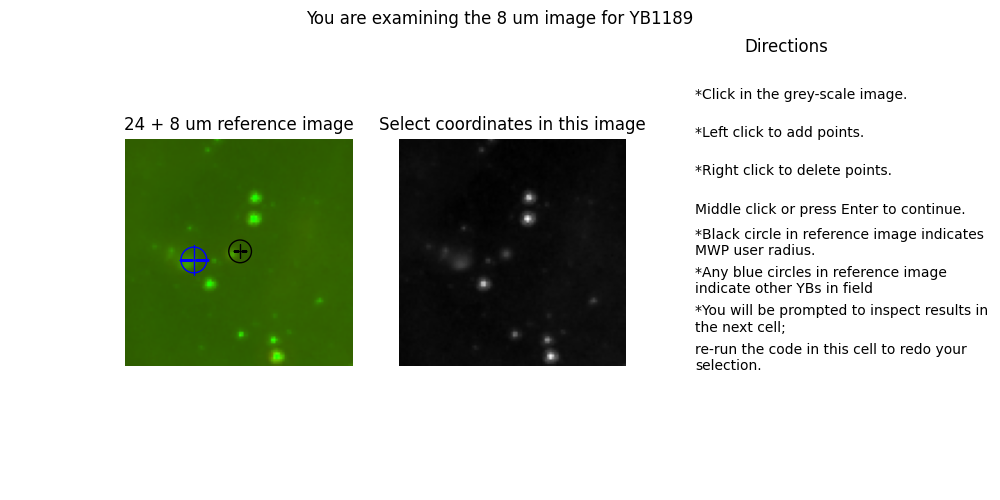

In [ ]:
%%capture --no-stdout --no-display
# @title
# need to update all this to have generalization to the um value
#return umselect index for everything
LinearThreshold= 0.001

origum=orig[umselect]

if np.isnan(origum.min()) == False and np.isnan(origum.max()) == False and origum.min() < origum.max():
  try:
    #reset global list coords that gets created in get_coords
    coords = []
    #get the coordinates by interacting with image
    get_coords_colab(workmask[umselect], wcsdata[umselect], selectedum, YB)
  except(ValueError):
    print('There is a problem in the image file. Skip to final step to assign results to table')
    coord = ' '
    flag = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
else:
    print('Image is saturated. Skip to final step to assign results to table')
    coord = ' '
    flag = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Run the cell below to see the mask and background removal results for the points you selected. If you wish to redo your point selection, run the above cell again. If you are satisfied, you can continue on to the next steps.

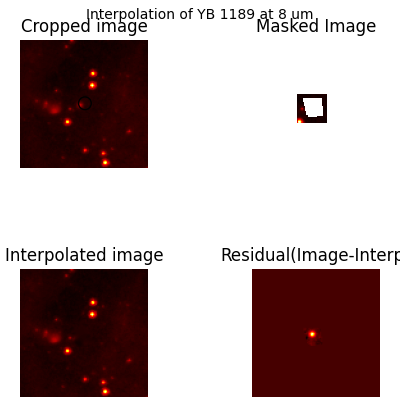

Please consult the residual image.
If you wish to redo your selction, re-run the previous cell and select different points.


In [ ]:

%%capture --no-stdout --no-display
# @title
#do the masking and interpolation on 70um image
#print('starting interp on coords', coordinates)
origum=orig[umselect]

if np.isnan(origum.min()) == False and np.isnan(origum.max()) == False and origum.min() < origum.max():
    coordinates = coords

    interp = do_interp(workmask[umselect], coordinates)
    diff = interp.resid
    #display the images
    make_figs(workmask[umselect], interp.blanked, interp.interp,
              interp.resid, images[umselect], wcsdata[umselect], selectedum)

    #save the coordinates to write to csv later
    coord = str(coordinates)

    #Prompt user to accept the selected region or redo
    print('Please consult the residual image.')
    print('If you wish to redo your selction, re-run the previous cell and select different points.')

else:
    print('Image is saturated. Skip to final step to assign results to table')
    coord = ' '
    flag = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Run the below cell to write the photometry results and flags out to your csv file. The displayed table will help you keep track of your progress.

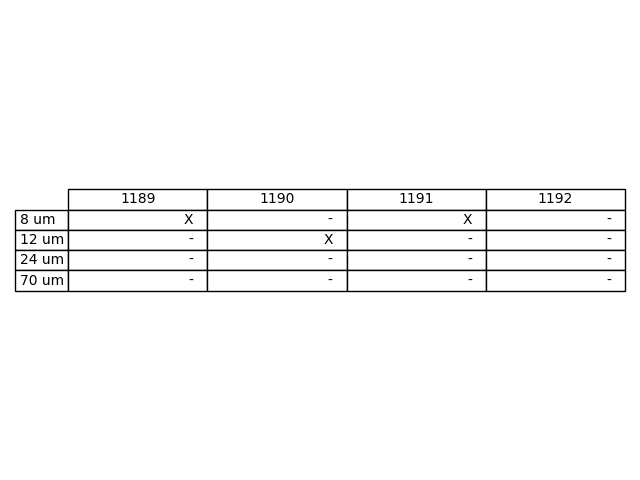

In [ ]:
%%capture --no-stdout --no-display
# @title
# Use residual images to perform photometry
#call the get_flux class


#determine with columns get the photometry, flags, and vertices information

if umselect == 0:
    vertices = 'vertices 8'
    photom = '8umphotom'
    flag1 = '8flag1'
    flag2 = '8flag2'
    flag3 = '8flag3'
    flag4 = '8flag4'
    flag5 = '8flag5'
    flag6 = '8flag6'
    flag7 = '8flag7'
    flag8 = '8flag8'
elif umselect == 1:
    vertices = 'vertices 12'
    photom = '12umphotom'
    flag1 = '12flag1'
    flag2 = '12flag2'
    flag3 = '12flag3'
    flag4 = '12flag4'
    flag5 = '12flag5'
    flag6 = '12flag6'
    flag7 = '12flag7'
    flag8 = '12flag8'
elif umselect == 2:
    vertices = 'vertices 24'
    photom = '24umphotom'
    flag1 = '24flag1'
    flag2 = '24flag2'
    flag3 = '24flag3'
    flag4 = '24flag4'
    flag5 = '24flag5'
    flag6 = '24flag6'
    flag7 = '24flag7'
    flag8 = '24flag8'
elif umselect == 3:
    vertices = 'vertices 70'
    photom = '70umphotom'
    flag1 = '70flag1'
    flag2 = '70flag2'
    flag3 = '70flag3'
    flag4 = '70flag4'
    flag5 = '70flag5'
    flag6 = '70flag6'
    flag7 = '70flag7'
    flag8 = '70flag8'
# write out to table with flags
df = pd.read_csv(out_name)

kk = str(YB)

origum=orig[umselect]

if np.isnan(origum.min()) == False and np.isnan(origum.max()) == False and origum.min() < origum.max():
  fluxval = get_flux_colab(diff, umselect)
  df.loc[df["YB"] == kk, photom] = round(fluxval.flux, 5)
else:
  df.loc[df["YB"] == kk, photom] = 'NaN'

df.loc[df["YB"] == kk, vertices] = coord

#COMMENTED OUT FLAGGING OPTION FOR NOW
#df.loc[df["YB"] == kk, flag1 ] = flag[0]
#df.loc[df["YB"] == kk, flag2 ] = flag[1]
#df.loc[df["YB"] == kk, flag3 ] = flag[2]
#df.loc[df["YB"] == kk, flag4 ] = flag[3]
#df.loc[df["YB"] == kk, flag5 ] = flag[4]
#df.loc[df["YB"] == kk, flag6 ] = flag[5]
#df.loc[df["YB"] == kk, flag7 ] = flag[6]
#df.loc[df["YB"] == kk, flag8 ] = flag[7]


df.to_csv(out_name, index=False)

#table to track progress
plt.close('all')
figtrack, axtrack = plt.subplots()
figtrack.patch.set_visible(False)
figtrack.canvas.header_visible = False
figtrack.canvas.footer_visible = False
figtrack.canvas.toolbar_visible = False
figtrack.canvas.resizable = False
axtrack.axis('off')
axtrack.axis('tight')

#update data to reflect what was just written out
dftrack.at[selectedum, kk]= 'X'
axtrack.table(cellText=dftrack.values, colLabels=dftrack.columns, rowLabels=dftrack.index, loc='center')
figtrack.tight_layout()
plt.show()
#print(dftrack)


Once the table updates, go back up to the cell under **"This is the iterative part to re-run for each photometric measurement!"** to choose your next YB and/or wavelength to analyze using the RADIO BUTTONS. When you have filled out the grid above, you can select a new YB range by COMPILING the cell at the start of this section again.

# Data Analysis: Plotting your results for the class activity

After you have completed photometry at all four wavelengths for at least ~20 sources, compile the two cells below to plot your data. These plots will help you analyze your results and compare your findings to those published in YB research papers. You can find a complete student activity guide using these plots [at this link.](https://docs.google.com/document/d/1OZbq1ASuaxKnqlOWJaeFUEsVO-3wsMAy1BD9dWf4WP8/edit?usp=sharing)

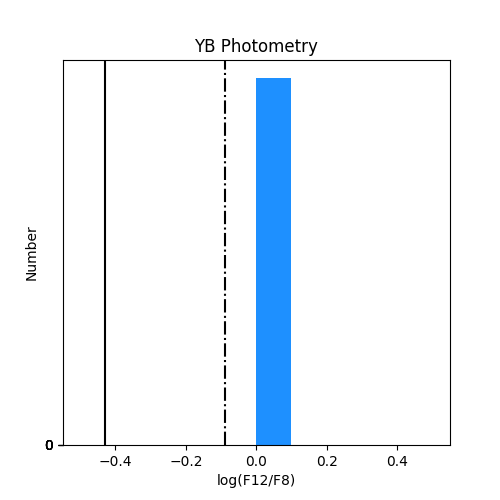

In [ ]:
%%capture --no-stdout --no-display
# @title
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

plt.close('all')
ybdataKD = pd.read_csv(out_name, usecols=['YB', '8umphotom','12umphotom','24umphotom', '70umphotom'])
hiGal=pd.read_csv(inputhg)
association = pd.read_csv(inputass)
ybdataWC = pd.read_csv(inputWC, usecols=['YB', '8umphotom','12umphotom','24umphotom'])


#The below is supposed to fill nan values with 0
ybdataKD = ybdataKD.fillna(value = 0)
ybdataWC = ybdataWC.fillna(value = 0)

stdev8um=np.zeros(len(ybdataKD))
stdev12um=np.zeros(len(ybdataKD))
stdev24um=np.zeros(len(ybdataKD))

normstdev8um=np.zeros(len(ybdataKD))
normstdev12um=np.zeros(len(ybdataKD))
normstdev24um=np.zeros(len(ybdataKD))

xcolor=np.zeros(len(ybdataKD))
ycolor=np.zeros(len(ybdataKD))
wisek=np.zeros(len(ybdataKD))
wisec=np.zeros(len(ybdataKD))
wiseq=np.zeros(len(ybdataKD))
wiseg=np.zeros(len(ybdataKD))
wiseall=np.zeros(len(ybdataKD))
rms=np.zeros(len(ybdataKD))

WCstdev8um=np.zeros(len(ybdataWC))
WCstdev12um=np.zeros(len(ybdataWC))
WCstdev24um=np.zeros(len(ybdataWC))

WCnormstdev8um=np.zeros(len(ybdataWC))
WCnormstdev12um=np.zeros(len(ybdataWC))
normstdev24um=np.zeros(len(ybdataWC))

WCxcolor=np.zeros(len(ybdataWC))
WCycolor=np.zeros(len(ybdataWC))
WCwisek=np.zeros(len(ybdataWC))
WCwisec=np.zeros(len(ybdataWC))
WCwiseq=np.zeros(len(ybdataWC))
WCwiseg=np.zeros(len(ybdataWC))
WCwiseall=np.zeros(len(ybdataWC))
WCrms=np.zeros(len(ybdataWC))

#Color ratios
kd12_8=[0]
kd24_8withzero=[0]
kd70_24withzero=[0]

for i in range(1, len(ybdataKD)):
    if float(ybdataKD['8umphotom'][i]) !=0 and float(ybdataKD['24umphotom'][i]) !=0 and float(ybdataKD['70umphotom'][i]) !=0:
        kd24_8withzero.append(np.log10(float(ybdataKD['24umphotom'][i])/float(ybdataKD['8umphotom'][i])))
        kd70_24withzero.append(np.log10(float(ybdataKD['70umphotom'][i])/float(ybdataKD['24umphotom'][i])))
        #print(i, kd24_8withzero[i], kd70_24withzero[i])
    else:
        kd24_8withzero.append(0)
        kd70_24withzero.append(0)

    if float(ybdataKD['12umphotom'][i]) != 0 and float(ybdataKD['8umphotom'][i]) !=0:
        kd12_8.append(np.log10(float(ybdataKD['12umphotom'][i])/float(ybdataKD['8umphotom'][i])))

wc12_8withzero=[]
wc24_8withzero=[]
wc24_12withzero=[]
for i in range(0, len(ybdataWC)):
    if float(ybdataWC['12umphotom'][i]) != 0 and float(ybdataWC['8umphotom'][i]) !=0:
        wc12_8withzero.append(np.log10(float(ybdataWC['12umphotom'][i])/float(ybdataWC['8umphotom'][i])))
        wc24_8withzero.append(np.log10(float(ybdataWC['24umphotom'][i])/float(ybdataWC['8umphotom'][i])))
        wc24_12withzero.append(np.log10(float(ybdataWC['24umphotom'][i])/float(ybdataWC['12umphotom'][i])))
    else:
        wc12_8withzero.append(0)
        wc24_8withzero.append(0)
        wc24_12withzero.append(0)

#kd70_24=np.log10(ybdataKD['70umphotom']/ybdataKD['24umphotom'])

#match up the hiGal and new photometry results
for i in range(1, len(ybdataKD)):

    xcolor[i]=kd70_24withzero[i]
    ycolor[i]=kd24_8withzero[i]

    for k in range(0, len(association)):
        if float(ybdataKD['YB'][i]) == float(association['YB'][k]):
            if association['WISE-Type'][k] == 'C':
                wisec[i]=1
            elif  association['WISE-Type'][k] == 'K':
                wisek[i]=1
            elif  association['WISE-Type'][k] == 'Q':
                wiseq[i]=1
                #print(i, 'this one should be blue')
            elif  association['WISE-Type'][k] == 'G':
                wiseg[i]=1
            if association['WISE-Type'][k] == 'C' or  association['WISE-Type'][k] == 'K' or association['WISE-Type'][k] == 'G':
                wiseall[i]=1
                #print(i, 'this one should be red')
            #elif  association['WISE-Type'][k] == 'Q':
            #    wiseq[i]=1
            if   association['RMS-ID'][k] > 0:
                rms[i]=1
                #print(i, 'this one should be boxed')

for i in range(0, len(ybdataWC)):
    #print(ybdataKD['YB'][i])
    for j in range(0, len(hiGal)):
        #print( hiGal['YB_1'][j])
        if float(ybdataWC['YB'][i]) == float(hiGal['YB_1'][j]) and float(ybdataWC['24umphotom'][i]) != 0:
            #print(ybdataKD['YB'], hiGal['YB_1'])
            WCxcolor[i]=np.log10(float(hiGal['F70'][j])/float(ybdataWC['24umphotom'][i]))
            WCycolor[i]=wc24_8withzero[i]
    for k in range(0, len(association)):
        if float(ybdataWC['YB'][i]) == float(association['YB'][k]):
            if association['WISE-Type'][k] == 'C':
                WCwisec[i]=1
            elif  association['WISE-Type'][k] == 'K':
                WCwisek[i]=1
            elif  association['WISE-Type'][k] == 'Q':
                WCwiseq[i]=1
            elif  association['WISE-Type'][k] == 'G':
                WCwiseg[i]=1
            if association['WISE-Type'][k] == 'C' or  association['WISE-Type'][k] == 'K' or association['WISE-Type'][k] == 'G':
                WCwiseall[i]=1
            #elif  association['WISE-Type'][k] == 'Q':
            #    WCwiseq[i]=1
            if   association['RMS-ID'][k] > 0:
                WCrms[i]=1


fig= plt.figure(figsize=(5,5))
fig.canvas.header_visible = False
plt.subplot(1,1,1,title=r'YB Photometry')
plt.hist(kd12_8, facecolor='dodgerblue')
plt.xlabel('log(F12/F8)')
plt.ylabel('Number')
plt.axvline(x=-0.09, color='black', linestyle='-.')
plt.axvline(x=-0.43, color='black')
# Make y axis only have even, whole number ticks. There may be a less clunky way to achieve this, but this works
yint = []
ytic = []
locs, labels = plt.yticks()
for each in locs:
    yint.append(int(each))
for i in range(0, max(yint)):
    if i not in yint:
        yint.append(i)
for num in yint:
    if num % 2 == 0:
       ytic.append(num)
plt.yticks(ytic)
plt.show()
#figurename=os.path.join(outpath, 'Histogram.png')
#fig.savefig(figurename)


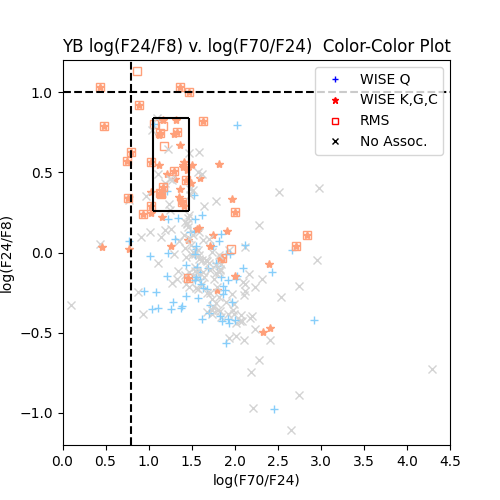

In [ ]:
%%capture --no-stdout --no-display
# @title
plt.close('all')
#24/8 v. 70/24 (compare with Anderson et al 2012 values for HII regions)
fig= plt.figure(figsize=(5,5))
fig.canvas.header_visible = False
plt.subplot(1,1,1,title=r'YB log(F24/F8) v. log(F70/F24)  Color-Color Plot')
plt.xlim(0,4.5)
plt.ylim(-1.2,1.2)
#print(xcolor, ycolor)
for i in range(0, len(ybdataWC)):
    if WCxcolor[i] != 0 and WCwiseq[i] !=0 and WCycolor[i] !=0:
        plt.plot(WCxcolor[i], WCycolor[i], '+', color='lightskyblue')
    if WCxcolor[i] != 0 and WCwiseall[i] !=0 and WCycolor[i] !=0:
        plt.plot(WCxcolor[i], WCycolor[i], '*', color='lightsalmon')
    if WCxcolor[i] != 0 and WCrms[i] !=0 and WCycolor[i] !=0:
        plt.plot(WCxcolor[i], WCycolor[i], 's', fillstyle='none', color='lightsalmon')
    if WCxcolor[i] != 0 and WCrms[i] ==0 and WCycolor[i] !=0 and WCwisek[i] == 0 and WCwisec[i] == 0 and WCwiseg[i] == 0 and WCwiseq[i] == 0:
        plt.plot(WCxcolor[i], WCycolor[i], 'x', color='lightgray')

for i in range(0, len(ybdataKD)):
    if xcolor[i] != 0 and wiseq[i] !=0 and ycolor[i] !=0:
        #print("plotting a blue one", i)
        plt.plot(xcolor[i], ycolor[i], '+', color='blue')
    if xcolor[i] != 0 and wiseall[i] !=0 and ycolor[i] !=0:
        #print("plotting a red one", i)
        plt.plot(xcolor[i], ycolor[i], '*', color='red')
    # if xcolor[i] != 0 and wisek[i] !=0 and ycolor[i] !=0:
    #     plt.plot(xcolor[i], ycolor[i], '+', color='red')
    # if xcolor[i] != 0 and wiseg[i] !=0 and ycolor[i] !=0:
    #     plt.plot(xcolor[i], ycolor[i], '*', color='green')
    # if xcolor[i] != 0 and wisec[i] !=0 and ycolor[i] !=0:
    #     plt.plot(xcolor[i], ycolor[i], '*', color='orange')
    if xcolor[i] != 0 and rms[i] !=0 and ycolor[i] !=0:
        plt.plot(xcolor[i], ycolor[i], 's', fillstyle='none', color='red')
    if xcolor[i] != 0 and rms[i] ==0 and ycolor[i] !=0 and wisek[i] == 0 and wisec[i] == 0 and wiseg[i] == 0 and wiseq[i] == 0:
        plt.plot(xcolor[i], ycolor[i], 'x', color='black')

WQ = mlines.Line2D([], [], color='blue', marker='+', markersize=5, linestyle='none', label='WISE Q')
WALL = mlines.Line2D([], [], color='red', marker='*', markersize=5, linestyle='none', label='WISE K,G,C')

RRMS = mlines.Line2D([], [], color='red', marker='s', markersize=5, fillstyle='none',linestyle='none', label='RMS')
NO = mlines.Line2D([], [], color='black', marker='x', markersize=5,linestyle='none', label='No Assoc.')
#plt.legend(handles=[WK, WQ, WG, WC, RRMS, NO])
plt.legend(handles=[WQ, WALL, RRMS, NO])

plt.xlabel('log(F70/F24)')
#plt.ylabel('log(F12/F8)')
plt.ylabel('log(F24/F8)')
plt.hlines(1.0, -0.5, 5, colors='k', linestyles='dashed', label='')
plt.vlines(0.8, -1.2, 1.2, colors='k', linestyles='dashed', label='')

plt.vlines(1.05, 0.26, 0.84, colors='k', linestyles='solid', label='')
plt.vlines(1.47, 0.26, 0.84, colors='k', linestyles='solid', label='')

plt.hlines(0.26, 1.05,1.47, colors='k', linestyles='solid', label='')
plt.hlines(0.84, 1.05, 1.47, colors='k', linestyles='solid', label='')
plt.show()

#figurename=os.path.join(outpath, 'Color-Color.png')
#fig.savefig(figurename)

#plt.close('all')

#calculating means
#kd24_12 = [x for x in kd24_12 if pd.isnull(x) == False]
#count24_12 = 0
#sum24_12 = 0
#for i in  range(0, len(kd24_12)):
#    if kd24_12[i] != 0:
#        sum24_12 = sum24_12 + kd24_12[i]
#        count24_12 = count24_12 + 1
#mean24_12 = sum24_12/count24_12

#print('mean 24/12 is:')
#print(mean24_12)

#kd12_8 = [x for x in kd12_8 if pd.isnull(x) == False]
#count12_8 = 0
#sum12_8 = 0
#for i in  range(0, len(kd12_8)):
#    if kd12_8[i] != 0:
#        sum12_8 = sum12_8 + kd12_8[i]
#        count12_8 = count12_8 + 1
#mean12_8 = sum12_8/count24_12

#print('mean 12/8 is:')
#print(mean12_8)


#overplot values from Anderson et al. (2012) Table 3
#https://www.aanda.org/articles/aa/full_html/2012/01/aa17640-11/T1.html

#